# Fairness and Explainability with SageMaker Clarify - Spark Distributed Processing

---

This notebook's CI test result for us-west-2 is as follows. CI test results in other regions can be found at the end of the notebook. 

![This us-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-2/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

---

## Runtime

This notebook takes approximately 30 minutes to run.

## Contents
1. [Overview](#Overview)
1. [Prerequisites and Data](#Prerequisites-and-Data)
    1. [Import Libraries](#Import-Libraries)
    1. [Set Configurations](#Set-Configurations)
    1. [Download data](#Download-data)
    1. [Loading the data: Adult Dataset](#Loading-the-data:-Adult-Dataset) 
    1. [Data inspection](#Data-inspection) 
    1. [Encode and Upload the Dataset](#Encode-and-Upload-the-Dataset) 
1. [Train and Deploy XGBoost Model](#Train-XGBoost-Model)
    1. [Train Model](#Train-Model)
    1. [Create Model](#Create-Model)
1. [Amazon SageMaker Clarify](#Amazon-SageMaker-Clarify)
    1. [Detecting Bias](#Detecting-Bias)
        1. [Writing DataConfig](#Writing-DataConfig)
        1. [Writing ModelConfig](#Writing-ModelConfig)
        1. [Writing ModelPredictedLabelConfig](#Writing-ModelPredictedLabelConfig)
        1. [Writing BiasConfig](#Writing-BiasConfig)
        1. [Pre-training Bias](#Pre-training-Bias)
        1. [Post-training Bias](#Post-training-Bias)
        1. [Viewing the Bias Report](#Viewing-the-Bias-Report)
    1. [Explaining Predictions](#Explaining-Predictions)
        1. [Viewing the Explainability Report](#Viewing-the-Explainability-Report)
        1. [Analysis of local explanations](#Analysis-of-local-explanations)
        1. [Visualize local SHAP values](#Visualize-local-SHAP-values)
1. [Clean Up](#Clean-Up)

## Overview
Amazon SageMaker Clarify helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models. The product comes with the tools to help you with the following tasks.

* Measure biases that can occur during each stage of the ML lifecycle (data collection, model training and tuning, and monitoring of ML models deployed for inference).
* Generate model governance reports targeting risk and compliance teams and external regulators.
* Provide explanations of the data, models, and monitoring used to assess predictions.

This sample notebook walks you through:  
1. Key terms and concepts needed to understand SageMaker Clarify
1. Measuring the pre-training bias of a dataset and post-training bias of a model
1. Explaining the importance of the various input features on the model's decision
1. Accessing the reports through SageMaker Studio if you have an instance set up.

In doing so, the notebook first trains a [SageMaker XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) model using training dataset, then use [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/) to launch SageMaker Clarify jobs to analyze an example dataset in CSV format. This notebook specifically showcases how to use Spark distributed processing for executing clarify jobs. 

## Prerequisites and Data
### Import Libraries

In [2]:
from sagemaker import session, get_execution_role
from io import StringIO
from s3fs import S3FileSystem
import sagemaker
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import boto3

### Set Configurations

In [3]:
# Initialize sagemaker session
sagemaker_session = session.Session()

region = sagemaker_session.boto_region_name
print(f"Region: {region}")

role = get_execution_role()
print(f"Role: {role}")

bucket = sagemaker_session.default_bucket()

prefix = "sagemaker/DEMO-sagemaker-clarify"

Region: us-west-2
Role: arn:aws:iam::000000000000:role/service-role/AmazonSageMaker-ExecutionRole-20220304T121686


### Download data
Data Source: [https://archive.ics.uci.edu/ml/machine-learning-databases/adult/](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/)

Let's __download__ the data and save it in the local folder with the name adult.data and adult.test from UCI repository$^{[2]}$.

$^{[2]}$Dua Dheeru, and Efi Karra Taniskidou. "[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml)". Irvine, CA: University of California, School of Information and Computer Science (2017).

In [4]:
from sagemaker.s3 import S3Downloader

adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]
if not os.path.isfile("adult.data"):
    S3Downloader.download(
        s3_uri="s3://{}/{}".format(
            f"sagemaker-example-files-prod-{region}", "datasets/tabular/uci_adult/adult.data"
        ),
        local_path="./",
        sagemaker_session=sagemaker_session,
    )
    print("adult.data saved!")
else:
    print("adult.data already on disk.")

if not os.path.isfile("adult.test"):
    S3Downloader.download(
        s3_uri="s3://{}/{}".format(
            f"sagemaker-example-files-prod-{region}", "datasets/tabular/uci_adult/adult.test"
        ),
        local_path="./",
        sagemaker_session=sagemaker_session,
    )
    print("adult.test saved!")
else:
    print("adult.test already on disk.")

adult.data saved!
adult.test saved!


### Loading the data: Adult Dataset
From the UCI repository of machine learning datasets, this database contains 14 features concerning demographic characteristics of 45,222 rows (32,561 for training and 12,661 for testing). The task is to predict whether a person has a yearly income that is more or less than $50,000.

Here are the features and their possible values:

1. **Age**: continuous.
1. **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
1. **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
1. **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
1. **Education-num**: continuous.
1. **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
1. **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
1. **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
1. **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
1. **Sex**: Female, Male.
    * **Note**: this data is extracted from the 1994 Census and enforces a binary option on Sex
1. **Capital-gain**: continuous.
1. **Capital-loss**: continuous.
1. **Hours-per-week**: continuous.
1. **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Next, we specify our binary prediction task: 

15. **Target**: <=50,000, >$50,000.

In [5]:
training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "adult.test", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?", skiprows=1
).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. Let's plot a few of the features that can be considered _sensitive_.  
Let's take a look specifically at the Sex feature of a census respondent. In the first plot we see that there are fewer Female respondents as a whole but especially in the positive outcomes, where they form ~$\frac{1}{7}$th of respondents.

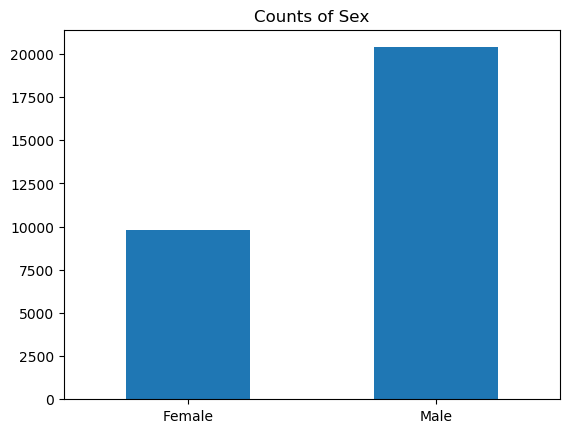

In [6]:
%matplotlib inline
training_data["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=0)

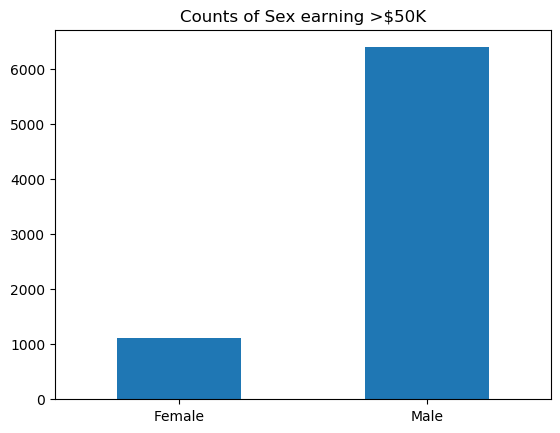

In [7]:
training_data["Sex"].where(training_data["Target"] == ">50K").value_counts().sort_values().plot(
    kind="bar", title="Counts of Sex earning >$50K", rot=0
)

### Encode and Upload the Dataset
Here we encode the training and test data. Encoding input data is not necessary for SageMaker Clarify, but is necessary for the model.

In [8]:
from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


training_data = pd.concat([training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
test_target = testing_data["Target"]
test_features.to_csv("test_features.csv", index=False, header=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


A quick note about our encoding: the "Female" Sex value has been encoded as 0 and "Male" as 1.

In [9]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


Lastly, let's upload the data to S3

In [10]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(bucket, prefix))

### Train XGBoost Model
#### Train Model
Since our focus is on understanding how to use SageMaker Clarify, we keep it simple by using a standard XGBoost model.

In [11]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="1.2-1")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=sagemaker_session,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-02-07-03-49-15-216



2023-02-07 03:49:15 Starting - Starting the training job..
2023-02-07 03:49:29 Starting - Preparing the instances for training..........
2023-02-07 03:50:24 Downloading - Downloading input data....
2023-02-07 03:50:49 Training - Downloading the training image.....
2023-02-07 03:51:19 Training - Training image download completed. Training in progress......
2023-02-07 03:51:50 Uploading - Uploading generated training model.
2023-02-07 03:52:01 Completed - Training job completed


#### Deploy Model
Here we create the SageMaker model.

In [12]:
from datetime import datetime

model_name = "DEMO-clarify-model-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
sagemaker_session.create_model(model_name, role, container_def)

INFO:sagemaker:Creating model with name: DEMO-clarify-model-07-02-2023-03-52-02


'DEMO-clarify-model-07-02-2023-03-52-02'

## Amazon SageMaker Clarify
With your model set up, it's time to explore SageMaker Clarify. For a general overview of how SageMaker Clarify processing jobs work, refer [the provided link](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-processing-job-configure-how-it-works.html).

When working with large datasets, you can use the Spark processing capabilities of SageMaker Clarify to enable your Clarify processing jobs to run faster. To use Spark processing for Clarify jobs, set the instance count to a number greater than one. Clarify uses Spark distributed computing when there is more than one instance per Clarify processor.

In [13]:
from sagemaker import clarify

# Initialize a SageMakerClarifyProcessor to compute bias metrics and model explanations with instance_count > 1
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=2, instance_type="ml.m5.xlarge", sagemaker_session=sagemaker_session
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Detecting Bias
SageMaker Clarify helps you detect possible [pre-training](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-detect-data-bias.html) and [post-training](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-detect-post-training-bias.html) biases using a variety of metrics.

#### Writing DataConfig
A [DataConfig](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.DataConfig) object communicates some basic information about data I/O to SageMaker Clarify. For our example here we provide the below information:

* `s3_data_input_path`: S3 URI of the train dataset we uploaded above
* `s3_output_path`: S3 URI at which our output report will be uploaded
* `label`: Specifies the ground truth label, which is also known as observed label or target attribute. It is used for many bias metrics. In this example, the `Target` column has the ground truth label.
* `headers`: The list of column names in the dataset
* `dataset_type`: specifies the format of your dataset, for this example as we are using CSV dataset this will be `text/csv`

In [14]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

#### Writing ModelConfig
A [ModelConfig](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.ModelConfig) object communicates information about your trained model. To avoid additional traffic to the production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing. For our example here we provide the below information:

* `model_name`: name of the concerned model, using name of the xgboost model trained earlier
* `instance_type` and `initial_instance_count` specify your preferred instance type and instance count used to run your model on during SageMaker Clarify's processing. Since we used two instances for the ClarifyProcessingJob, we recommend that you also increase the number of instances in the model configuration. This is to prevent the processing instances from being bottle necked by the shadow endpoint.
* `accept_type` denotes the endpoint response payload format, and `content_type` denotes the payload format of request to the endpoint. As per the example model we created above both of these will be `text/csv`.

In [15]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=2,
    accept_type="text/csv",
    content_type="text/csv",
)

#### Writing ModelPredictedLabelConfig
A [ModelPredictedLabelConfig](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.ModelPredictedLabelConfig) provides information on the format of your predictions. XGBoost model outputs probabilities of samples, so SageMaker Clarify invokes the endpoint then uses `probability_threshold` to convert the probability to binary labels for bias analysis. Prediction above the threshold is interpreted as label value `1` and below or equal as label value `0`.

In [16]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

#### Writing BiasConfig
[BiasConfig](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.BiasConfig) contains configuration values for detecting bias using a Clarify container.

In [17]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="Sex", facet_values_or_threshold=[0], group_name="Age"
)

For our demo we provide the following information in BiasConfig API:

* `label_values_or_threshold`: List of label value(s) or threshold to indicate positive outcome used for bias metrics. Here positive outcome is earning >$50,000.
* `facet_name`: Sensitive columns of the dataset, "Sex" is the category
* `facet_values_or_threshold`: values of the sensitive group, "Female" respondents are the sensitive group.
* `group_name`: This example has selected the "Age" column which is used to form subgroups for the measurement of bias metric [Conditional Demographic Disparity (CDD)](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-data-bias-metric-cddl.html) or [Conditional Demographic Disparity in Predicted Labels (CDDPL)](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-post-training-bias-metric-cddpl.html).

SageMaker Clarify can handle both categorical and continuous data for `facet: values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data. The results will show if the model has a preference for records of one sex over the other.

#### Pre-training Bias
Bias can be present in your data before any model training occurs. Inspecting your data for bias before training begins can help detect any data collection gaps, inform your feature engineering, and help you understand what societal biases the data may reflect.

Computing pre-training bias metrics does not require a trained model.

#### Post-training Bias
Computing post-training bias metrics does require a trained model.

Unbiased training data (as determined by concepts of fairness measured by bias metric) may still result in biased model predictions after training. Whether this occurs depends on several factors including hyperparameter choices.


You can run these options separately with `run_pre_training_bias()` and `run_post_training_bias()` or at the same time with `run_bias()` as shown below. We use following additional parameters for the api call:

* `pre_training_methods`: Pre-training bias metrics to be computed. The detailed description of the metrics can be found on [Measure Pre-training Bias](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-measure-data-bias.html). This example sets methods to "all" to compute all the pre-training bias metrics.
* `post_training_methods`: Post-training bias metrics to be computed. The detailed description of the metrics can be found on [Measure Post-training Bias](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-detect-post-training-bias.html). This example sets methods to "all" to compute all the post-training bias metrics.

In [ ]:
# The job takes about 10 minutes to run
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)

#### Viewing the Bias Report
In Studio, you can view the results under the experiments tab.

<img src="./recordings/bias_report.gif">

Each bias metric has detailed explanations with examples that you can explore.

<img src="./recordings/bias_detail.gif">

You could also summarize the results in a handy table!

<img src="./recordings/bias_report_chart.gif">


If you're not a Studio user yet, you can access the bias report in PDF, HTML and ipynb formats in the following S3 bucket:

In [19]:
bias_report_output_path

's3://sagemaker-us-west-2-000000000000/sagemaker/DEMO-sagemaker-clarify/clarify-bias'

### Explaining Predictions
There are expanding business needs and legislative regulations that require explanations of _why_ a model made the decision it did. SageMaker Clarify uses Kernel SHAP to explain the contribution that each input feature makes to the final decision.

For run_explainability API call we need similar `DataConfig` and `ModelConfig` objects we defined above. [SHAPConfig](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.SHAPConfig) here is the config class for Kernel SHAP algorithm.

For our demo we pass the following information in `SHAPConfig`:

* `baseline`: Kernel SHAP algorithm requires a baseline (also known as background dataset). If not provided, a baseline is calculated automatically by SageMaker Clarify using K-means or K-prototypes in the input dataset. Baseline dataset type shall be the same as dataset_type, and baseline samples shall only include features. By definition, baseline should either be a S3 URI to the baseline dataset file, or an in-place list of samples. In this case we chose the latter, and put the mean of the train dataset to the list. For more details on baseline selection please [refer this documentation](https://docs.aws.amazon.com/en_us/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html).
* `num_samples`: Number of samples to be used in the Kernel SHAP algorithm. This number determines the size of the generated synthetic dataset to compute the SHAP values. 
* `agg_method`: Aggregation method for global SHAP values. For our example here we are using `mean_abs` i.e. mean of absolute SHAP values for all instances
* `save_local_shap_values`: Indicates whether to save the local SHAP values in the output location. Default is True.

In [20]:
explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

baseline = [training_data.mean().iloc[1:].values.tolist()]
shap_config = clarify.SHAPConfig(
    baseline=baseline,
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

In [ ]:
# The job takes about 10 minutes to run
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)

#### Viewing the Explainability Report
As with the bias report, you can view the explainability report in Studio under the experiments tab


<img src="./recordings/explainability_detail.gif">

The Model Insights tab contains direct links to the report and model insights.

If you're not a Studio user yet, as with the Bias Report, you can access this report at the following S3 bucket.

In [22]:
explainability_output_path

's3://sagemaker-us-west-2-000000000000/sagemaker/DEMO-sagemaker-clarify/clarify-explainability'

#### Analysis of local explanations
It is possible to visualize the local explanations for single examples in your dataset. You can use the obtained results from running Kernel SHAP algorithm for global explanations.

In [23]:
analysis_result_json = sagemaker.s3.S3Downloader.read_file(
    explainability_output_path + "/analysis.json"
)
analysis_result = json.loads(analysis_result_json)
shap_values = analysis_result["explanations"]["kernel_shap"]["label0"]["global_shap_values"]
features = pd.Series(shap_values)
feature_names = features.index
feature_names

Index(['Age', 'Capital Gain', 'Capital Loss', 'Country', 'Education',
       'Education-Num', 'Ethnic group', 'Hours per week', 'Marital Status',
       'Occupation', 'Relationship', 'Sex', 'Workclass', 'fnlwgt'],
      dtype='object')

With Clarify Spark jobs, the output files that contain local SHAP values will be split into multiple files. You will need to collate them before you can visualize them.

In [24]:
_s3 = boto3.resource("s3")
my_bucket = _s3.Bucket(bucket)
s3_files = [
    "s3://{}/{}".format(obj.bucket_name, obj.key)
    for obj in my_bucket.objects.filter(
        Prefix=prefix + "/clarify-explainability/explanations_shap/out.csv/"
    )
    if obj.key.endswith(".csv")
]
print(f"Found {len(s3_files)} files in S3")

Found 128 files in S3


In [25]:
# For the sake of time, open a subset of the s3 files
num_files_to_open = len(s3_files)
local_shap_values = pd.DataFrame()
for file in s3_files[:num_files_to_open]:
    output = sagemaker.s3.S3Downloader.read_file(file)
    df = pd.read_csv(StringIO(output), sep=",")
    local_shap_values = local_shap_values.append(df, ignore_index=True)

#### Visualize local SHAP values

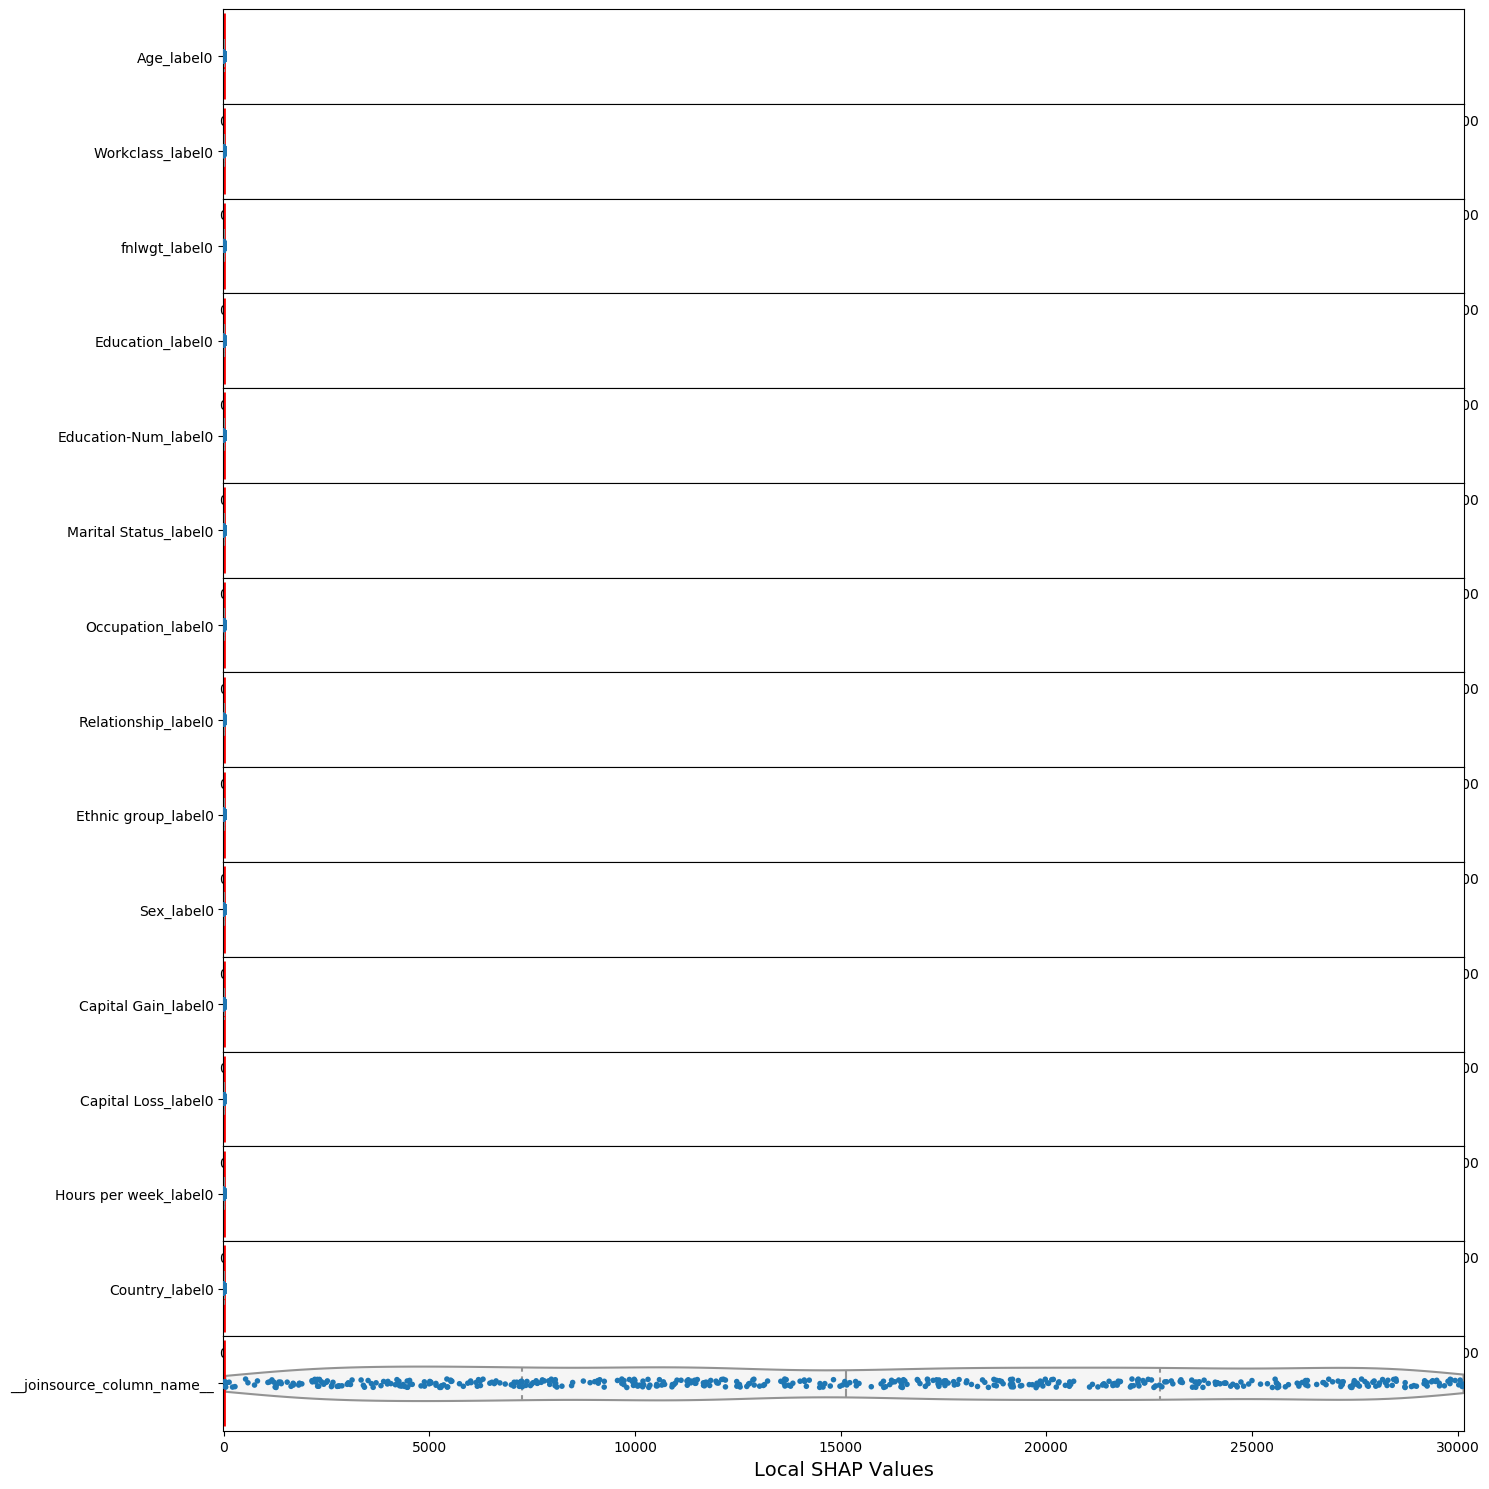

In [26]:
max_features_to_display = 15
feature_names = local_shap_values.columns

fig = plt.figure(figsize=(max_features_to_display, max_features_to_display))
low = local_shap_values.min().min()
high = local_shap_values.max().max()

i = 1
for feature_name in feature_names:
    plt.subplot(max_features_to_display, 1, i)
    shap_value = local_shap_values[f"{feature_name}"].to_frame()
    feature = pd.Series([feature_name] * shap_value.shape[0]).to_frame()
    df = pd.concat([shap_value, feature], axis=1, join="inner", ignore_index=True)
    df.columns = ["shap_value", "feature"]
    num_rows_to_display = min(df.shape[0], 500)
    df = df.sample(num_rows_to_display)
    ax = sns.violinplot(
        y="feature",
        x="shap_value",
        data=df,
        size=6,
        color="#f5f5f5",
        inner="quartile",
        bw=0.2,
        cut=0,
        orient="h",
    )
    ax.set_xlim(low, high)
    sns.stripplot(
        y="feature",
        x="shap_value",
        data=df,
        size=4,
        orient="h",
    )
    ax.vlines(0, -1, 1, color="#ff0000", linewidth=2)
    ax.set_ylabel("")
    ax.legend([], [], frameon=False)
    i += 1


plt.xlabel("Local SHAP Values", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0.1)

plt.show()

**Note:** You can run both bias and explainability jobs at the same time with `run_bias_and_explainability()`, refer [API Documentation](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.SageMakerClarifyProcessor.run_bias_and_explainability) for more details.

### Clean Up
Finally, don't forget to clean up the resources we set up and used for this demo!

In [28]:
sagemaker_session.delete_model(model_name)

INFO:sagemaker:Deleting model with name: DEMO-clarify-model-07-02-2023-03-52-02


## Notebook CI Test Results

This notebook was tested in multiple regions. The test results are as follows, except for us-west-2 which is shown at the top of the notebook.

![This us-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-1/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This us-east-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-east-2/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This us-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/us-west-1/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This ca-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ca-central-1/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This sa-east-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/sa-east-1/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This eu-west-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-1/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This eu-west-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-2/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This eu-west-3 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-west-3/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This eu-central-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-central-1/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This eu-north-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/eu-north-1/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This ap-southeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-1/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This ap-southeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-southeast-2/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This ap-northeast-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-1/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This ap-northeast-2 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-northeast-2/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)

![This ap-south-1 badge failed to load. Check your device's internet connectivity, otherwise the service is currently unavailable](https://prod.us-west-2.tcx-beacon.docs.aws.dev/sagemaker-nb/ap-south-1/sagemaker-clarify|fairness_and_explainability|fairness_and_explainability_spark.ipynb)
